In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
df = pd.read_csv('Train_raw.tsv', delimiter='\t')
#df = df[:1000]

# Data cleaning 

##### 1)Date to MM/DD/YYYY format (Changing Jan 1, 2001 to 01/01/2001)
##### 2)Changing Unnamed column to rating_id

In [ ]:
import datetime
df['date'] = pd.to_datetime(df['date'])
df = df.rename(columns={'Unnamed: 0': 'rating_id'})
df['date'] = df['date'].apply(lambda x: datetime.datetime.strftime(x, '%m/%d/%Y'))
#for demo purposes:
#df.head()

##### Line chart of drug ratings:

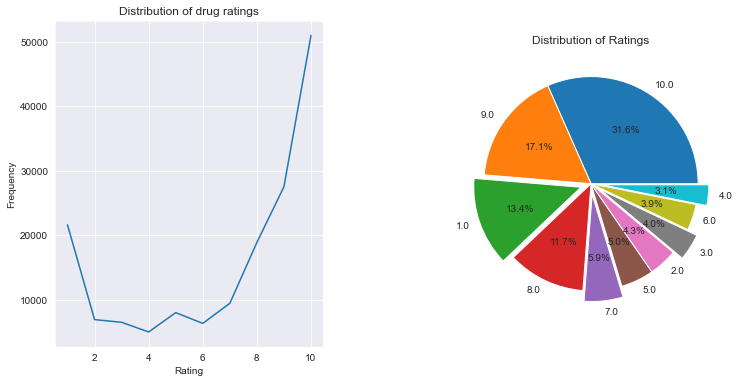

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

axes[0].plot(df['rating'].value_counts().sort_index())
axes[0].set_title('Distribution of drug ratings')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Frequency')

rating_counts = df['rating'].value_counts()

explode = [0, 0, 0.1, 0, 0.1, 0, 0, 0.1, 0, 0.1]
axes[1].pie(rating_counts, labels=rating_counts.index, autopct='%1.1f%%', explode=explode)
axes[1].set_title('Distribution of Ratings')

fig.set_size_inches(12, 6)
plt.subplots_adjust(wspace=0.5)
plt.show()


1) Line chart of patient ratings helps to see how many patients rated the drugs highly and how many rated them poorly.

2) The pie chart on the right provides additonal aid in understanding the distribution of patient ratings. 

##### Bar chart of top 10 drugs by review count:

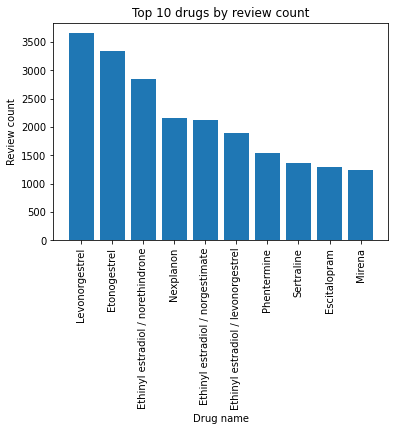

In [ ]:
top_drugs = df['drugName'].value_counts().nlargest(10)
plt.bar(top_drugs.index, top_drugs.values)
plt.title('Top 10 drugs by review count')
plt.xlabel('Drug name')
plt.ylabel('Review count')
plt.xticks(rotation=90)
plt.show()


Bar chart of drug frequency: This bar chart shows the frequency of top 10 most mentioned drugs in the dataset.

### Top 10 most common conditions in the dataset

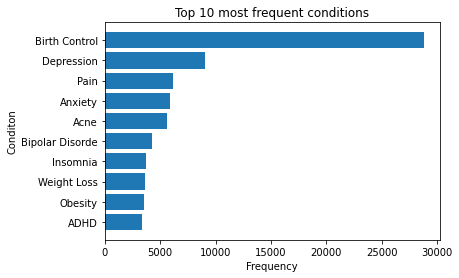

In [ ]:
top_drugs = df['condition'].value_counts().nlargest(10)[::-1]

plt.barh(top_drugs.index, top_drugs.values)
plt.title('Top 10 most frequent conditions')
plt.xlabel('Frequency')
plt.ylabel('Conditon')

plt.show()


This horizontal bar plot visualizes the top 10 most frequent conditions found in a given dataset.

##### Scatter plot of rating vs. useful count:

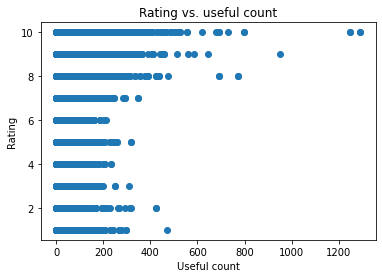

In [ ]:
plt.scatter(df['usefulCount'], df['rating'], alpha=1)
plt.title('Rating vs. useful count')
plt.xlabel('Useful count')
plt.ylabel('Rating')
plt.show()


Scatter plot of rating vs useful count: This scatter plot shows the relationship between patient ratings and the number of users who found the review useful. 
From this we can infer that there seems to be no visible correlation between the ratings and the usefulCount for the drug reviews. It is possible, ratings were not influenced by the review or people using the drug did not seek the review's opinion.

##### Word cloud of common words in reviews:

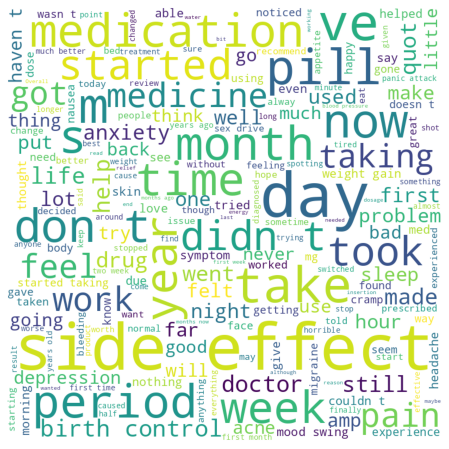

In [ ]:
from wordcloud import WordCloud

# Concatenate all reviews into one string
reviews = ' '.join(df['review'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(reviews)

# Display the word cloud
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


Word cloud of patient reviews: This word cloud visualizes the most common words used in patient reviews. This gives an idea of the most common complaints or compliments patients have about the drugs.

# Time Series graph

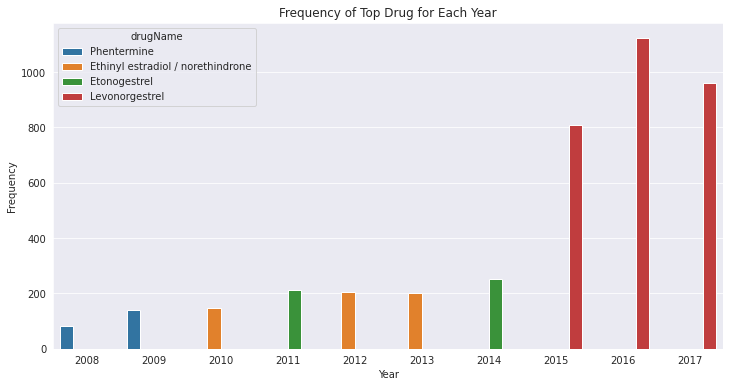

In [ ]:
#Extract the year from the 'date' column.
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

#Count the frequency of each drug for each year: 
freq_df = df.groupby(['year', 'drugName']).size().reset_index(name='frequency')

#Get the drug with the highest frequency for each year:
top_drug_df = freq_df.loc[freq_df.groupby('year')['frequency'].idxmax()]

sns.set_style('darkgrid')

plt.figure(figsize=(12, 6))
sns.barplot(x='year', y='frequency', hue='drugName', data=top_drug_df)
plt.title('Frequency of Top Drug for Each Year')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()


** Add analysis for chart above

##### Cleaning the reviews column

In [ ]:
#import time
#start_time = time.time()

import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tag import pos_tag
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))
# Define a function to clean the review column
def clean_reviews(review):

    # Remove special characters and lower case the review
    review = re.sub(r'[^\w\s]|\d','', review).lower()

    # Removing stop words
    words = [word for word in nltk.word_tokenize(review) if word not in stop_words]

    
    # remove words with less than 2 charcters
    words = [word for word in words if len(word) > 1]
        
    # Extract adjectives and adverbs from the review
    words = [word for (word, pos) in nltk.pos_tag(words) if pos.startswith('JJ') or pos.startswith('RB')]

    return ' '.join(words)

df['review'] = df['review'].apply(clean_reviews)
#df

#end_time = time.time()
#time_elapsed = end_time - start_time
#print("Time elapsed:", time_elapsed, "seconds")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


###### Categorizing reviews based on rating into good/bad/average (from 'ratings')

In [ ]:
df['rating_category'] = pd.cut(df['rating'], bins=[0, 4, 7, 10], labels=['bad', 'average', 'good'])
df.groupby(['rating_category']).count()

rating_count_df = df['rating_category'].value_counts().to_frame().reset_index()
rating_count_df.columns = ['rating_category', 'count']
rating_count_df

,rating_category,count
0,good,97410
1,bad,40075
2,average,23812


##### Distribution of rating categories:

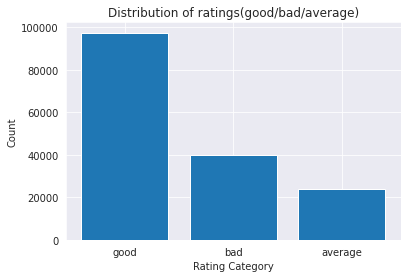

In [ ]:
ratings = df['rating_category'].value_counts()
plt.bar(ratings.index, ratings.values)
plt.title('Distribution of ratings(good/bad/average)')
plt.xlabel('Rating Category')
plt.ylabel('Count')
plt.show()


# Logistic Regression model (predicts rating category based on text reviews)

In [ ]:
# Input test dataset
df2 = pd.read_csv('Test_raw.tsv', delimiter='\t')

# Clean test dataset
#df2['review'] = df2['review'].apply(clean_reviews)

# Set actual rating column to compare with model predictions later
df2['rating_category'] = pd.cut(df2['rating'], bins=[0, 4, 7, 10], labels=['bad', 'average', 'good'])


In [ ]:
#start_time = time.time()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression

reviews_train = df['review']
categories_train = df['rating_category']

reviews_test = df2['review']
categories_test = df2['rating_category']

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(reviews_train)
X_test = vectorizer.transform(reviews_test)

logreg = LogisticRegression(max_iter=5000)
logreg.fit(X_train, categories_train)

predictions = logreg.predict(X_test)

accuracy = accuracy_score(categories_test, predictions)
print('Accuracy:', accuracy)

df_copy = df2.copy()
df_copy = df_copy.iloc[0]

review = [df_copy['review']]
category = [df_copy['rating_category']]
single_test = vectorizer.transform(review)
single_predict = logreg.predict(single_test)
print('Testing on single review')
print(review)
print('Prediction:', single_predict, 'Actual:', category)
#end_time = time.time()
#time_elapsed = end_time - start_time
#print("Time elapsed:", time_elapsed, "seconds")


Accuracy: 0.7055388163523416
Testing on single review
['"I&#039;ve tried a few antidepressants over the years (citalopram, fluoxetine, amitriptyline), but none of those helped with my depression, insomnia &amp; anxiety. My doctor suggested and changed me onto 45mg mirtazapine and this medicine has saved my life. Thankfully I have had no side effects especially the most common - weight gain, I&#039;ve actually lost alot of weight. I still have suicidal thoughts but mirtazapine has saved me."']
Prediction: ['good'] Actual: ['good']


#### Accuracy Report from the model

In [ ]:
print(classification_report(categories_test, predictions))

              precision    recall  f1-score   support

     average       0.37      0.07      0.11      7920
         bad       0.69      0.52      0.59     13497
        good       0.72      0.94      0.82     32349

    accuracy                           0.71     53766
   macro avg       0.59      0.51      0.51     53766
weighted avg       0.66      0.71      0.66     53766



## K-Means Clustering (clusters reviews based on ratings, drugName, condition)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


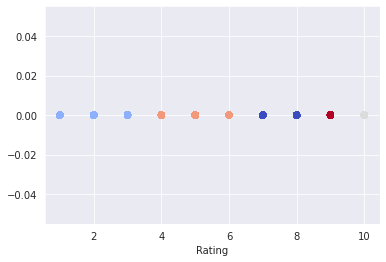

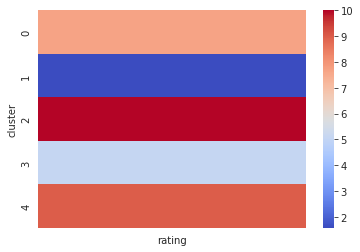



Cluster 0 size: 28346
<bound method NDFrame.head of 1         halfway fourth concerned last highest dose har...
3         first form glad patch first longer also intens...
9         many rx effective really completely acne extra...
20        lyme full blown quotquot viral high never comb...
25        prescribed mg light mild alleviate later still...
                                ...                        
161237    great adverse yet many psychiatric never depre...
161247    january numerous actually ache initial prior f...
161276    ago excessive diazepam around lorazepam gradua...
161288    prozac nowafter ago terrible take prozac sexua...
161290    tekturna also calcium tekturna diovan ugly how...
Name: review, Length: 28346, dtype: object>


Cluster 1 size: 35063
<bound method NDFrame.head of 5         nd hard however lower rd amp severe lower cant...
6                               cummed later later pregnant
8                            constant legs amp severe light
14      

In [ ]:
#start_time = time.time()

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


# encode categorical variables
df3 = df.copy()
df3 = pd.get_dummies(df3, columns=['condition', 'drugName'])

# combine the features into a single matrix
X = df3[['rating']].join(df.filter(regex='^condition_|^drugName_'))

# standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# choose the clustering algorithm and number of clusters
kmeans = KMeans(n_clusters=5, random_state=0)

# fit the model to the data
kmeans.fit(X_scaled)

# visualize the clusters using a scatter plot
plt.scatter(X['rating'], [0] * len(X), c=kmeans.labels_, cmap='coolwarm')
plt.xlabel('Rating')
plt.show()


# create a new dataframe with cluster labels
df_clustered = X.copy()
df_clustered['cluster'] = kmeans.labels_

# create a heatmap
sns.heatmap(df_clustered.groupby('cluster').mean(), cmap='coolwarm')
plt.show()

# analyze the reviews within each cluster
for i in range(kmeans.n_clusters):
    print("\n")
    cluster = df[kmeans.labels_ == i]
    print(f"Cluster {i} size: {len(cluster)}")
    print(cluster['review'].head)


#end_time = time.time()
#time_elapsed = end_time - start_time
#print("Time elapsed:", time_elapsed, "seconds")


## Agglomerative Clustering

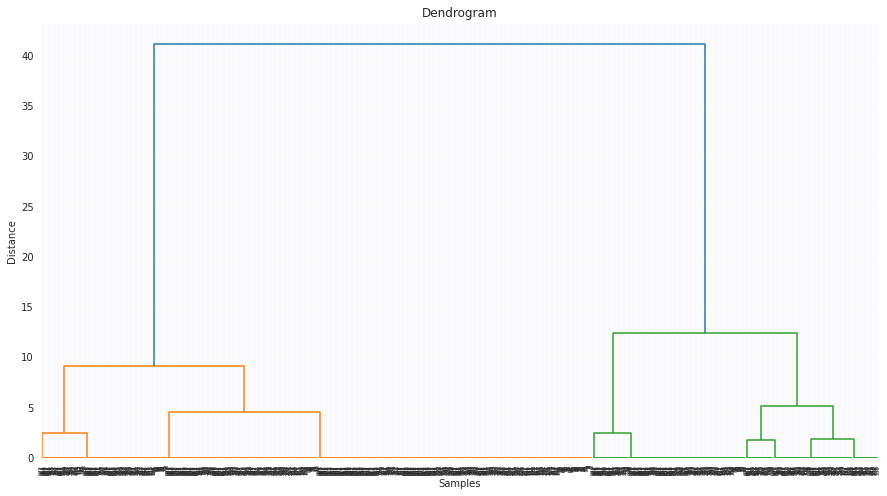

Cluster 0 size: 508
4792      phentermine little immediately medicine first ...
142824    due continually usually also awful everyday li...
72063         allergic new terribly nearest faster allergic
110597                                                     
60368     first extremely irregular painful bc ive extre...
Name: review, dtype: object
Cluster 1 size: 151
97316     actually learn endometriomas dermoid always se...
21700     serious back severe terrible medication maybe ...
155360    enbrel various rheumatoid totally free stiffne...
114951                                           really mgs
127768    methotrexate several great ive ago ive already...
Name: review, dtype: object
Cluster 2 size: 183
45925     sadly good regular amoxicillin ineffective ear...
94900     unprotected effective cheaper fast forward tow...
142600    yr old diabetic worse first really harder litt...
106480                             first ago worse dry safe
516       necon first bad worse better nortr

In [ ]:
#start_time = time.time()

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage


#sampling just 5000 from our original dataset
#df4= df.sample(n=5000, random_state=42).copy()
df4= df.sample(n=1000, random_state=42).copy()

# encode categorical variables
df4 = pd.get_dummies(df4, columns=['condition', 'drugName'])

# combine the features into a single matrix
X = df4[['rating']].join(df.filter(regex='^condition_|^drugName_'))

# standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# choose the clustering algorithm and number of clusters
agg_clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

# fit the model to the data and obtain linkage matrix
linkage_matrix = linkage(X_scaled, method='ward')

plt.figure(figsize=(15,8))
dendrogram(linkage_matrix)
plt.title('Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()

# choose the number of clusters based on the dendrogram
n_clusters = 5

# apply clustering to the data
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
labels = agg_clustering.fit_predict(X_scaled)

# analyze the reviews within each cluster
for i in range(n_clusters):
    cluster = df4[labels == i]
    print(f"Cluster {i} size: {len(cluster)}")
    print(cluster['review'].head())

#end_time = time.time()
#time_elapsed = end_time - start_time
#print("Time elapsed:", time_elapsed, "seconds")
